In [1]:
import numpy as np
import sympy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_curve, auc, accuracy_score
from tensorflow.keras.utils import to_categorical

# Load dataset

In [2]:
from sklearn.datasets import fetch_openml
data = fetch_openml('hls4ml_lhc_jets_hlf')
X, Y = data['data'].to_numpy(), data['target'].to_numpy()
print(data['feature_names'])
print(X.shape, Y.shape)
print(Y[:10])

LE = LabelEncoder()
Y = LE.fit_transform(Y)

Y = to_categorical(Y, 5)

Y=2*Y-1
print(Y[:10])

['zlogz', 'c1_b0_mmdt', 'c1_b1_mmdt', 'c1_b2_mmdt', 'c2_b1_mmdt', 'c2_b2_mmdt', 'd2_b1_mmdt', 'd2_b2_mmdt', 'd2_a1_b1_mmdt', 'd2_a1_b2_mmdt', 'm2_b1_mmdt', 'm2_b2_mmdt', 'n2_b1_mmdt', 'n2_b2_mmdt', 'mass_mmdt', 'multiplicity']
(830000, 16) (830000,)
['g' 'w' 't' 'z' 'w' 'w' 't' 'g' 'z' 'g']
[[ 1. -1. -1. -1. -1.]
 [-1. -1. -1.  1. -1.]
 [-1. -1.  1. -1. -1.]
 [-1. -1. -1. -1.  1.]
 [-1. -1. -1.  1. -1.]
 [-1. -1. -1.  1. -1.]
 [-1. -1.  1. -1. -1.]
 [ 1. -1. -1. -1. -1.]
 [-1. -1. -1. -1.  1.]
 [ 1. -1. -1. -1. -1.]]


In [3]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.5, random_state=123)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# PySR not happy with too many training data (>10000)
X_train = X_train[:8000]
Y_train = Y_train[:8000]

print('X_train.shape: ' + str(X_train.shape))
print('Y_train.shape: ' + str(Y_train.shape))
print('X_test.shape: ' + str(X_test.shape))
print('Y_test.shape: ' + str(Y_test.shape))

X_train.shape: (8000, 16)
Y_train.shape: (8000, 5)
X_test.shape: (415000, 16)
Y_test.shape: (415000, 5)


# Run PySR (from command line for interactive mode)

In [ ]:
from pysr import PySRRegressor
!export JULIA_NUM_THREADS=32

model_pysr = PySRRegressor(
    model_selection='accuracy',
    niterations=40,
    timeout_in_seconds=60*60*1,
    maxsize=40,
    select_k_features=6,
    binary_operators=['+', '-', '*'],
    unary_operators=[
        'sin',
        'sc(x)=sin(x)*cos(x)'
    ],
    complexity_of_operators={'+': 1, '-': 1, '*': 1, 'sin': 1, 'sc': 1},
    constraints={'sin': 20, 'sc': 20},
    nested_constraints={
        'sin': {'sin': 0, 'sc': 0},
        'sc':  {'sin': 0, 'sc': 0}
    },
    extra_sympy_mappings={'sc': lambda x: sympy.sin(x)*sympy.cos(x)},
    loss='L2MarginLoss()' #(1 - y*y')^2
)

In [ ]:
model_pysr.fit(X_train, Y_train)

# Convert to HLS project using hls4ml

In [4]:
from pysr import PySRRegressor
model_pysr = PySRRegressor.from_file('example.pkl')
with sympy.evaluate(True):
    for i in range(5):
        print('Tagger {} = '.format(i)+str(model_pysr.sympy()[i])+'\n------------------------------------------')

Checking if example.pkl exists...
Loading model from example.pkl
Tagger 0 = -0.1630426*(sc(-0.75052315) - 0.84283006)*sc(2*x14 - 1.03665108) - sin(x14 - (0.9237657 - 0.11933863*x3)*(-x15 + 2*x2 - 0.3817056) + 1.761264957)
------------------------------------------
Tagger 1 = (-(0.5822144*sc(0.83811*x14) - 0.5324657)*(sc(0.3923645*x2) - 0.63548696) + sc(x14 - 0.3923645*x15 + x3 + 0.51168373))*(0.561041303633489*sin(x15) - 0.47277835) - 0.84055585
------------------------------------------
Tagger 2 = 0.49239117*(sc(x3) + sc(x15 + 0.76784414*x3))*(sc(-0.13417026) + sc(0.5180547) + sc(x2)) - sin(x14 + 0.25715914*x15*x3 - x2 - x3 + 0.66443527)
------------------------------------------
Tagger 3 = 0.41071504*(0.9298677 - sin(0.59376544*x15))*(sc(x14) + 5.2546763*sc(0.71913457 - x3))*(-sc(2*x3) + sc(5.2546763*x14 + x3 + 0.77032656) + 0.32492808) - 0.863786752431664
------------------------------------------
Tagger 4 = (1.0745832 - sc(-x14 - 0.4094719))*(-0.15737492*x15 - sc(x14 - 4.2594776) +

In [5]:
model_pysr.set_params(extra_sympy_mappings={"sc": lambda x: sympy.sin(x)*sympy.cos(x)})
model_pysr.refresh()
class sc(sympy.Function):
    pass

from hls4ml.utils.symbolic_utils import init_pysr_lut_functions
function_definitions = ['sin_lut(x) = math_lut(sin, x, N=256, range_start=-8, range_end=8)',
                        'cos_lut(x) = math_lut(cos, x, N=256, range_start=-8, range_end=8)']
init_pysr_lut_functions(init_defaults=True, function_definitions=function_definitions)

lut_functions = {
    'sin_lut': {
        'math_func': 'sin',
        'range_start': -8,
        'range_end': 8,
        'table_size': 256
    },
    'cos_lut': {
        'math_func': 'cos',
        'range_start': -8,
        'range_end': 8,
        'table_size': 256
    }
}

expr = []
expr_lut = []
for i in range(5):
    expr.append(str(model_pysr.sympy()[i]))
    expr_lut.append(expr[i].replace("sin", "sin_lut").replace("cos", "cos_lut"))
    print('expr =\n' + expr[i])
    print("----------------------------------------")
    print('expr_LUT =\n' + expr_lut[i])
    print("========================================")
    expr[i] = sympy.parsing.sympy_parser.parse_expr(expr[i])
    expr_lut[i] = sympy.parsing.sympy_parser.parse_expr(expr_lut[i])

import hls4ml
hls_model = hls4ml.converters.convert_from_symbolic_expression(expr,
                                                               n_symbols=16,
                                                               output_dir='my-hls-test',
                                                               precision='ap_fixed<16,6>',
                                                               part='xcvu9p-flga2577-2-e',
                                                               #lut_functions=lut_functions,
                                                               hls_include_path='/data/containers/cmd/include',
                                                               hls_libs_path='/data/containers/cmd/lnx64'
                                                               )
hls_model.write()
hls_model.compile()

hls_model_lut = hls4ml.converters.convert_from_symbolic_expression(expr_lut,
                                                                   n_symbols=16,
                                                                   output_dir='my-hls-test-lut',
                                                                   precision='ap_fixed<16,6>',
                                                                   part='xcvu9p-flga2577-2-e',
                                                                   lut_functions=lut_functions,
                                                                   hls_include_path='/data/containers/cmd/include',
                                                                   hls_libs_path='/data/containers/cmd/lnx64'
                                                                   )
hls_model_lut.write()
hls_model_lut.compile()

/afs/cern.ch/work/h/htsoi/miniconda3/envs/sr/lib/python3.9/site-packages/hls4ml/converters/__init__.py:26: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!")


expr =
0.218740281461912*sin(2*x14 - 1.03665108)*cos(2*x14 - 1.03665108) - sin(x14 - (0.9237657 - 0.11933863*x3)*(-x15 + 2*x2 - 0.3817056) + 1.761264957)
----------------------------------------
expr_LUT =
0.218740281461912*sin_lut(2*x14 - 1.03665108)*cos_lut(2*x14 - 1.03665108) - sin_lut(x14 - (0.9237657 - 0.11933863*x3)*(-x15 + 2*x2 - 0.3817056) + 1.761264957)
expr =
(-(0.5822144*sin(0.83811*x14)*cos(0.83811*x14) - 0.5324657)*(sin(0.3923645*x2)*cos(0.3923645*x2) - 0.63548696) + sin(x14 - 0.3923645*x15 + x3 + 0.51168373)*cos(x14 - 0.3923645*x15 + x3 + 0.51168373))*(0.561041303633489*sin(x15) - 0.47277835) - 0.84055585
----------------------------------------
expr_LUT =
(-(0.5822144*sin_lut(0.83811*x14)*cos_lut(0.83811*x14) - 0.5324657)*(sin_lut(0.3923645*x2)*cos_lut(0.3923645*x2) - 0.63548696) + sin_lut(x14 - 0.3923645*x15 + x3 + 0.51168373)*cos_lut(x14 - 0.3923645*x15 + x3 + 0.51168373))*(0.561041303633489*sin_lut(x15) - 0.47277835) - 0.84055585
expr =
0.49239117*(sin(x2)*cos(x2) + 0

# Compare outputs of PySR vs HLS vs HLS(LUT)

In [6]:
test_vector=np.random.rand(1,16)*4-2
test_vector

array([[-0.8290663 ,  1.89328309,  0.42506525, -1.71617287,  1.83329105,
        -0.63483527,  1.56435901,  1.89248919,  0.92587714,  0.57613587,
         1.56415341,  0.48852389, -0.55574837, -1.84378967,  1.17289196,
        -0.61795002]])

In [7]:
model_pysr.predict(test_vector)

array([[-0.93592861, -0.90455188,  0.41470415, -1.07241199, -0.6620568 ]])

In [8]:
hls_model.predict(test_vector)

array([-0.93652344, -0.90234375,  0.41601562, -1.07617188, -0.66503906])

In [9]:
hls_model_lut.predict(test_vector)

array([-0.92871094, -0.8828125 ,  0.39160156, -1.09570312, -0.67578125])

# Compare PySR and HLS performance

In [10]:
Y_pysr = model_pysr.predict(X_test)
Y_hls = hls_model.predict(X_test)
Y_hls_lut = hls_model_lut.predict(X_test)
auc_pysr=[]
auc_hls=[]
auc_hls_lut=[]
for x, label in enumerate(LE.classes_):
    fpr_pysr, tpr_pysr, _ = roc_curve(Y_test[:, x], Y_pysr[:, x])
    fpr_hls, tpr_hls, _ = roc_curve(Y_test[:, x], Y_hls[:, x])
    fpr_hls_lut, tpr_hls_lut, _ = roc_curve(Y_test[:, x], Y_hls_lut[:, x])
    auc_pysr.append(auc(fpr_pysr, tpr_pysr))
    auc_hls.append(auc(fpr_hls, tpr_hls))
    auc_hls_lut.append(auc(fpr_hls_lut, tpr_hls_lut))

print('PySR acc    = {0:.3f}'.format(accuracy_score(np.argmax(Y_test, axis=1), np.argmax(Y_pysr, axis=1))))
print('PySR auc    = {0:.3f},{1:.3f},{2:.3f},{3:.3f},{4:.3f}'.format(auc_pysr[0],auc_pysr[1],auc_pysr[2],auc_pysr[3],auc_pysr[4]))
print('HLS acc     = {0:.3f}'.format(accuracy_score(np.argmax(Y_test, axis=1), np.argmax(Y_hls, axis=1))))
print('HLS auc     = {0:.3f},{1:.3f},{2:.3f},{3:.3f},{4:.3f}'.format(auc_hls[0],auc_hls[1],auc_hls[2],auc_hls[3],auc_hls[4]))
print('HLS_LUT acc = {0:.3f}'.format(accuracy_score(np.argmax(Y_test, axis=1), np.argmax(Y_hls_lut, axis=1))))
print('HLS_LUT auc = {0:.3f},{1:.3f},{2:.3f},{3:.3f},{4:.3f}'.format(auc_hls_lut[0],auc_hls_lut[1],auc_hls_lut[2],auc_hls_lut[3],auc_hls_lut[4]))

PySR acc    = 0.723
PySR auc    = 0.909,0.868,0.923,0.892,0.879
HLS acc     = 0.723
HLS auc     = 0.909,0.868,0.923,0.892,0.879
HLS_LUT acc = 0.722
HLS_LUT auc = 0.908,0.867,0.923,0.895,0.882


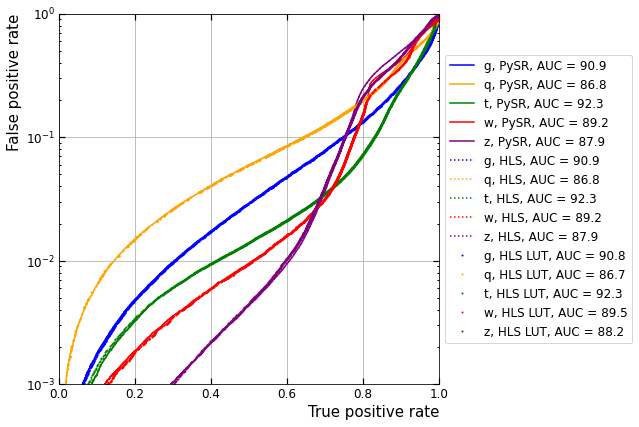

In [11]:
def plot_roc(y_test, y_pred, labels, model):
    color = ['blue','orange','green','red','purple']
    for x, label in enumerate(labels):        
        fpr, tpr, _ = roc_curve(y_test[:, x], y_pred[:, x])
        if model == 'pysr':
            plt.plot(tpr, fpr, label='{0}, PySR, AUC = {1:.1f}'.format(label, auc(fpr, tpr)*100.), linestyle='solid', color=color[x], lw=1.5)
        if model == 'hls':
            plt.plot(tpr, fpr, label='{0}, HLS, AUC = {1:.1f}'.format(label, auc(fpr, tpr)*100.), linestyle='dotted', color=color[x], lw=1.5)
        if model == 'hls_lut':
            plt.plot(tpr, fpr, label='{0}, HLS LUT, AUC = {1:.1f}'.format(label, auc(fpr, tpr)*100.), linestyle='None',  color=color[x], lw=1, marker='o',ms=1)
    plt.semilogy()
    plt.xlabel('True positive rate', size=15, loc='right')
    plt.ylabel('False positive rate', size=15, loc='top')
    plt.tick_params(axis='both', which='major', direction='in', length=6, width=1.2, labelsize=12, right=True, top=True)
    plt.tick_params(axis='both', which='minor', direction='in', length=2, width=1, labelsize=12, right=True, top=True)
    plt.xlim(0, 1)
    plt.ylim(0.001, 1)
    plt.grid(True)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=12)  
    
plt.figure(figsize=(15, 15))
axes = plt.subplot(2,2,1)
plot_roc(Y_test, Y_pysr, LE.classes_, 'pysr')
plot_roc(Y_test, Y_hls, LE.classes_, 'hls')
plot_roc(Y_test, Y_hls_lut, LE.classes_, 'hls_lut')

# Run synthesis from command line

In [ ]:
source /data/tools/Xilinx/Vivado/2020.1/settings64.sh
source /data/setup_xilinx_lic.sh

In [ ]:
!vivado_hls -f build_prj.tcl "reset=1 synth=1 csim=0 cosim=0 validation=0 export=0 vsynth=1"

In [ ]:
!cat my-hls-test/myproject_prj/solution1/syn/report/myproject_csynth.rpt